In [1]:
!pip install wandb matplotlib scikit-learn regex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 74.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 64.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 72.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.1/774.1 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 88.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.8 MB/s eta 0:00:00
   ━━━━━━

In [2]:
import string
import math
import random
import wandb
import json
import torch
import torch.functional as F
import torch.distributions as dist
from torch.optim.lr_scheduler import _LRScheduler
from torch import optim, nn, arange
from torch.utils.data import Dataset, DataLoader

In [2]:
wandb.login()

wandb: Currently logged in as: 1a3orn. Use `wandb login --relogin` to force relogin


True

In [3]:
#
#
# ---------------------------------------------
# Data loading + tokenizing -- Create a PRE-SHUFFLED + tokenized data
# ----------------------------------------------
# (Liberally copied from Karpathy's https://github.com/karpathy/minbpe)
#
#

In [4]:
import regex as re
import string
import json

def get_stats(ids, c = None):
    counts = {} if c is None else c
    # iter consecutive elements
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge(ids, pair, idx):
    newids = []
    i = 0
    while i < len(ids):
        # if not at the very last position AND the pair matches, replace it
        if ids[i] == pair[0] and i < len(ids) - 1 and ids[i+1] == pair[1]:
            newids.append(idx)
            i += 2
        else:
            newids.append(ids[i])
            i += 1
    return newids

GPT4_SPLIT_PATTERN = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""

class Tokenizer():
    """
    Simple BPE implementation following Karpathy / GPT-4 to avoid cross word splits
    """
    def __init__(self):
        self.vocab = None
        self.merges = None
        self.BASE = string.printable

    def train(self, file_name: str, vocab_size:int) -> None:

        with open(file_name, 'r', encoding='utf-8') as file:
            text = file.read()
        print("1: Have read file ", file_name)

        # I've been using a peel from project gutenberg that
        # replaces accented characters with generic, drops other
        # characters not in string.printable, and excludes
        # texts with more than 1 in 100,000 thin
        for c in text:
            if c not in self.BASE:
                raise Exception("Not in BASE!")
        print("2: Verified all in BASE")

        assert vocab_size >= len(self.BASE)
        num_merges = vocab_size - len(self.BASE)

        text_chunks = re.findall(GPT4_SPLIT_PATTERN, text)
        ids = [[ self.BASE.index(c) for c in text ] for text in text_chunks ]

        merges = {} # (int, int) -> int
        vocab = {idx: self.BASE[idx] for idx in range(len(self.BASE))}
    

        for i in range(num_merges):
            stats = {}
            for chunk_ids in ids:
                get_stats(chunk_ids, stats)
                
            pair = max(stats, key=stats.get)
            if not pair:
                break
            idx = len(self.BASE) + i

            ids = [merge(chunk_ids, pair, idx) for chunk_ids in ids]

            merges[pair] = idx
            vocab[idx] = vocab[pair[0]] + vocab[pair[1]]

            if i % 1 == 0:
                print(f"merge {i+1}/{num_merges}: {pair} -> {idx} ({vocab[idx]}) had {stats[pair]} occurrences")

        self.merges = merges
        self.vocab = vocab

    def save(self, file_name):
        if self.merges is None or self.vocab is None:
            raise Exception("")
        with open(file_name, 'w') as f:
            merges = { (str(k[0]) + "-" + str(k[1])) : v for k, v in m.merges.items() }
            vocab = { str(k): v for k, v in self.vocab.items() }
            to_save = { "merges": merges, "vocab": vocab }
            json.dump(to_save, f, indent=4)

    def load(self, file_name):
        with open(file_name, 'r') as f:
            data = json.load(f)
            self.merges = { tuple(map(int, k.split('-'))): v for k, v in data["merges"].items() }
            self.vocab = { int(k): v for k, v in data["vocab"].items() }

    def decode(self, ids):
        return "".join(self.vocab[idx] for idx in ids)


    def _encode_chunk(self, text):
        # return the token ids
        # let's begin. first, convert all bytes to integers in range 0..255
        ids = [ self.BASE.index(c) for c in text ]
        while len(ids) >= 2:
            # find the pair with the lowest merge index
            stats = get_stats(ids)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges:
                break # nothing else can be merged anymore
            idx = self.merges[pair]
            ids = merge(ids, pair, idx)
        return ids

    def encode(self, text):

        text_chunks = re.findall(GPT4_SPLIT_PATTERN, text)
        ids = []
        print("Text length: ", len(text), len(text_chunks))
        for i, ch in enumerate(text_chunks):
            chunk_ids = self._encode_chunk(ch)
            if i % 5000000 == 0:
                print(i)
            ids.extend(chunk_ids)
        return ids

In [5]:
#!head -n 121620 shorter.txt > even_shorter.txt

In [6]:
#m = Tokenizer()
#m.train("shorter.txt", 2048)

In [7]:
import time
import os

def get_text_files(folder_path):
    text_files = []
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            text_files.append(os.path.join(folder_path, file))
    return text_files

def make_text_dataset(folder_name, train_name, test_name, tokenizer, ratio_mod=300, ctx_len=841):

        file_names = get_text_files(folder_name)

        print("Doing file names ", file_names)
        data = []
        data_test = []
        for i, file_name in enumerate(file_names):
            print("\n\n", i)
            with open(file_name, 'r', encoding='utf-8') as file:
                text = file.read()
            print("1. Read file: ", file_name)
            print(" - file length: ", len(text))
    
            # Filter out non-string characters
            print("2. Tokenizing: ")
            t = time.time()
            tokens = tokenizer.encode(text)
            print(" - tokenized length: ", len(tokens))
            print(" - time ", time.time() - t)
    
            # Create chunks of ctx_len
            i = 0
            while((i + 1) * ctx_len < len(tokens)):
                if i % ratio_mod == 0:
                    data_test.append(tokens[i * ctx_len:(i + 1) * ctx_len])
                    i = i + 1
                else:
                    data.append(tokens[i * ctx_len:(i + 1) * ctx_len])
                    i = i + 1
            print("3. Chunked into train and test: ", len(data), len(data[0]))

        random.shuffle(data)
        random.shuffle(data_test)


        train_stacked = torch.tensor(data, dtype=torch.short)
        test_stacked = torch.tensor(data_test, dtype=torch.short)
        print("train_stacked", train_stacked.size())
        print("test_stacked", test_stacked.size())

        torch.save(train_stacked, train_name)
        torch.save(test_stacked, test_name)
        print("Done")

In [8]:
tokenizer = Tokenizer()
tokenizer.load("vocab.json")

In [9]:
#make_text_dataset("data", "full_train.pt", "full_test.pt", tokenizer)

In [10]:
def show_tensor(tensor):
    assert len(tensor.size()) == 1
    strg = ''
    for i in range(len(tensor)):
        strg = strg + string.printable[tensor[i].item()]
    return strg

def show_texts(file_name, tokenizer, num_to_show=30):
    tensor = torch.load(file_name)

    for i in range(num_to_show):
        row = tensor[i]
        strg = tokenizer.decode(row.tolist())
        print("\n\n", i, "\n\n", row.size())
        print(strg)

show_texts("full_test.pt", tokenizer)



 0 

 torch.Size([841])
 unusual--and
mysterious-looking, and strangely out of place where it was. It looked as
though an army of workmen had come along with hammers and had broken up
tons of sandstone and slate, and then filled in between the boulders with
rubble, making a smooth and narrow road that in places was ground to the
fineness of powder and the hardness of cement. But instead of hammers, the
hoofs of a hundred or perhaps a thousand generations of mountain sheep had
made the trail. It was the sheep-path over the range. The first band of
bighorn may have blazed the way before Columbus discovered America; surely
it had taken a great many years for hoofs to make that smooth road among
the rocks.

Thor used the path as one of his highways from valley to valley, and there
were other creatures of the mountains who used it as well as he, and more
frequently. As he stood waiting for Muskwa to get his wind they both heard
an odd chuckling sound approaching them from above. Forty or 

In [11]:
# --------------------------------------------------
# GENERIC TRANSFORMER PARTS
# --------------------------------------------------
#
# Exactly the same in a MoE and a Dense transformer
# - Causal Mask
# - SelfAttention

In [12]:
# Vanilla causal attention mask + hard-alibi
# ------------------------------------------
# Hard Alibi (https://arxiv.org/pdf/2402.01032.pdf) is a variant of
# the Alibi position encoding (https://arxiv.org/pdf/2108.12409.pdf)
# where Alibi's slow linear decay over the attention is replaced by
# a discrete decay such that
# - the first head sees one token back
# - the second, two
# - the third, four, and so on
# ------
# Init:
# - config["max_length"] = maximum length sequence fed into it
# Forward:
# - takes [b, t, t] or [b, nh, t, t]
#
class HardAlibiCausalMask(nn.Module):
    def __init__(self, config, short=False):
        super().__init__()
        self.max_seq_len = msl = config["model_max_length"]
        self.n_heads = n_heads = config["num_heads"]
        rel = self.get_relative_positions(msl)
        stack = []
        bases = config["head_bases"]
        for i in range(n_heads):
            bools = (rel <= 0) & (rel > -int(bases[i]))
            ready = torch.where(bools, torch.zeros(rel.shape), float("-inf"))
            stack.append(ready)
        self.register_buffer("values", torch.stack(stack, dim=0))

    def get_relative_positions(self, seq_len):
        x = torch.arange(seq_len)[None, :]
        y = torch.arange(seq_len)[:, None]
        return x - y

    def forward(self, att):
        sizes = att.size()
        t1, t2 = sizes[-2:]
        assert t1 == t2, "attention must be square"
        assert t1 <= self.max_seq_len, "attention must be smaller than max_seq_length"
        reshaped_att = att.view(-1, self.n_heads, t1, t1)
        return reshaped_att + self.values[:,:t1,:t1]

def test():
    m = torch.rand(2, 4, 5, 5)
    m = HardAlibiCausalMask({ "model_max_length": 6, "num_heads": 4, "head_bases": [1,2,4,8] }, short=True)(m)
    # To get a feel for how hard-alibi works uncomment
    #print(m)
    assert m[0][0][0][0] > 0
    assert m[0][0][1][1] > 0
    assert m[0][0][0][1] == float("-inf")

#test()

In [13]:
# Vanilla multi-headed self-attention implementation
# ------------------------------------------------
# Init:
# - config["hidden_dim"] = int, dimension of input
# - config["num_heads"] = int, number of heads, head_size = hidden_dim // num_heads
# - config["max_length"] = int, sets masks size for the CausalMask
# Forward:
# - takes [b, t, c]
# - outputs [b, t, c]
class SelfAttention(nn.Module):

    def __init__(self, config, index, short=False):
        super().__init__()
        self.hidden_dim = hd = config["hidden_dim"]
        self.num_heads = nh = config["num_heads"]
        self.k = nn.Linear(hd, hd)
        self.q = nn.Linear(hd, hd)
        self.v = nn.Linear(hd, hd)
        self.p = nn.Linear(hd, hd) # Projection from heads to output
        self.mask = HardAlibiCausalMask(config, short=short)

    def forward(self, x):
        b, t, c = x.size()

        num_heads = self.num_heads
        heads_dim = c // num_heads
        k = self.k(x).view(b, t, num_heads, heads_dim).transpose(1, 2)
        q = self.q(x).view(b, t, num_heads, heads_dim).transpose(1, 2)
        v = self.v(x).view(b, t, num_heads, heads_dim).transpose(1, 2)

        # Mult-headed attention: [b, nh, t, hd] @ [b, nh, hd, ] -> [b, nh, t, t]
        att = q @ k.transpose(-2, -1)
        att = att / math.sqrt(k.size(-1))
        att = self.mask(att)
        att = torch.softmax(att, dim=-1)

        # [b, nh, t, t] x [b, nh, t, hs] -> [b, nh, t, hs]
        y = att @ v
        
        # [b, nh, t, hs] -> [b, t, nh, hs] -> [b, t, c]
        y = y.transpose(1, 2).contiguous().view(b, t, c)
        
        return self.p(y)

def test_simple_att():
    m = SelfAttention({
        "hidden_dim": 32,
        "model_max_length": 4,
        "num_heads": 4,
    }, 1, short=True).to("cuda")
    out = m(torch.randn(16 * 32, 4, 32).to("cuda"))
    print(out.size())
    print(out.reshape(16 * 32, 4, 32).size())

#test_simple_att()

In [14]:
# --------------------------------------------------
# MLP vs MOE
# --------------------------------------------------
#
# - MLP
# - UnitCenteredNoise (used in SwitchMoE)
# - SwitchMoE

In [15]:
# MLP module
# -------------------------------
# Note: Signature of init here matches init for MoE
#
# Init:
# - config["hidden_dim"] = dimension of c in [b, t, c] input
# - index = int index
# - scaling = amount by which to scale weights
# Forward:
# - tuple (tensor, aux_loss)
# -- tensor is [b, t, c]
# -- aux_loss is a scalar added to cross-entropy loss
#
class MLP(nn.Module):

    def __init__(self, config, index, scaling=1.0, expansion_factor=4):
        super().__init__()
        self.hidden_dim = hd = config["hidden_dim"]
        self.expansion_factor = expansion_factor
        self.seq = nn.Sequential(*[
            nn.Linear(hd, int(hd * expansion_factor)),
            nn.ReLU(),
            nn.Linear(int(hd * expansion_factor), hd),
        ])
        
        with torch.no_grad():
            self.seq[0].weight.data *= scaling
            self.seq[2].weight.data *= scaling
            self.seq[0].bias.data *= scaling
            self.seq[2].bias.data *= scaling   

    def forward(self, inp_tuple):
        x, aux_loss = inp_tuple
        return self.seq(x), aux_loss

In [16]:
# Elementwise multiplies: x * (1 +- eps)
# -------------------------------
# Init:
# - scaling = amount by which 1 varies
# Forward:
# - any tensor
#
class UnitCenteredNoise(nn.Module):
    def __init__(self, scaling=0.02):
        super(UnitCenteredNoise, self).__init__()
        self.scaling = scaling
        self.base = 1 - (scaling * 0.5)

    def forward(self, x):
        if self.training:
            # uniform 1-centered noise
            noise = torch.rand(x.size()).to(x.device)
            noise_centered = (noise * self.scaling) + self.base
            return x * noise_centered
        else:
            return x

In [17]:
# Actual Switch Mixture-of-Experts Layer
# -------------------------------
# Note: Signature of init here matches init for MLP
#
# Init:
# - config["hidden_dim"] = Dimension of c in [b, t, c] input
# - config["num_experts"] = A layer indexed array of how many
#                           experts are per layer
# - config["init_moe_scaling"] = Amount by which to scale
#                                weights in MoE experts. If you don't
#                                make them smaller, then it doesn't 
#                                learn as well for mysterious reasons.
#                                
# Forward:
# - tuple (tensor, aux_loss)
# -- tensor is [b, t, c]
# -- aux_loss is a scalar added to cross-entropy loss
class SwitchMoE(nn.Module):

    def __init__(self, config, index):
        super().__init__()

        self.train_idx = 0
        self.hidden_dim = hd = config["hidden_dim"]
        self.num_experts = num_experts = config["num_experts"][index]
        self.num_exp_per_token = config["num_exp_per_token"]
        self.moe_scaling = moe_scaling = config["init_moe_scaling"]
        self.moe_expansion_factor = mef = config["moe_expansion_factor"]
        
        self.experts = nn.ModuleList([
            MLP(config, index=index, scaling=moe_scaling, expansion_factor=mef)
            for index
            in range(num_experts)
        ])

        self.gate = nn.Sequential(
            nn.Linear(hd, config["num_experts"][index]),
            UnitCenteredNoise(scaling=0.02),
            nn.Softmax(dim=-1)
        )

        self.ln = nn.LayerNorm([hd])
        

    def forward(self, xx):
        inp, aux_loss = xx
        b, t, c = inp.shape

        self.train_idx = self.train_idx + 1

        # Reshape to [b * t, c], makes it easier to think about
        inp = inp.reshape(b * t, c)
        
        gate_val_continuous = self.gate(inp) # [b * t, c] -> [b * t, num_gates]
        _, gate_val_indices = torch.topk(
            gate_val_continuous,
            self.num_exp_per_token,
            dim=-1
        ) # [b * t, num_gates] -> [b * t, 1]
        
        # Map [b * t, 1] a one-hot [b * t, num_experts] where the last dim is one-hot encoded
        one_hot = torch.nn.functional.one_hot(gate_val_indices, num_classes=self.num_experts).sum(1)

        # Calculate auxillary loss to balance the experts
        f = one_hot.sum(dim=0) # [b * t, num_experts] -> [num_experts]
        if self.train_idx % 10000 == 0:
            print(f)
        f = f / f.sum()
        P = gate_val_continuous.sum(dim=0) # [b * t, num_experts] -> [num_experts]
        P = P / P.sum()

        extra_aux_loss = (P * f).sum() * self.num_experts

        output = torch.zeros_like(inp)
        for i in range(self.num_experts):
            
            mask = one_hot[:,i] == 1 # mask shape: [b * t]
            mask_expand = mask.unsqueeze(-1).expand_as(output) # to [b * t, c]
      
            inp_for_expert = inp[mask_expand].reshape(-1, c)
            out_from_exp, _ = self.experts[i]((inp_for_expert, torch.zeros([1])))

            output[mask_expand] =+ out_from_exp.reshape(-1)
          
        return self.ln(output.reshape(b, t, c)), extra_aux_loss + aux_loss
        
        
def test():
    a = torch.ones(7) / torch.ones(7).sum()
    b = torch.ones(7) / torch.ones(7).sum()
    print((a * b).sum())
    
    m = torch.randn(16, 32, 48).to("cuda")
    nm = SwitchMoE({
        "hidden_dim": 48,
        "num_experts": [8,8,8],
        "init_moe_scaling": 1.0,
        "moe_expansion_factor": 4,
        "num_exp_per_token": 2,
        "extra_fake_experts": 2,
    }, 1).to("cuda")
    out = nm((m, torch.zeros([1]).to("cuda")))

#test()

In [18]:
from torch import nn

class TransformerBlock(nn.Module):

    def __init__(self, config, index):
        super().__init__()
        self.index = index
        self.hidden_dim = hd = config["hidden_dim"]
        self.attention = SelfAttention(config, index)

        # Switch between a MoE and a MLP layer according to config
        self.layer_type = config["layer_types"][index]
        if config["layer_types"][index] == "switch":
            self.ff = SwitchMoE(config, index)
        elif config["layer_types"][index] == "mlp":
            self.ff = MLP(config, index, expansion_factor=config["expansion_factors"][index])
        else:
            raise Exception("Invalid layer type")

        
        self.att_norm1 = nn.LayerNorm([hd])
        self.att_norm2 = nn.LayerNorm([hd])
        self.ff_norm = nn.LayerNorm([hd])

    def forward(self, input_tuple):
        x, extra_loss = input_tuple

        x_att = self.attention(self.att_norm1(x))
        x = x + self.att_norm2(x_att)

        x_ff, extra_loss = self.ff((self.ff_norm(x), extra_loss))
        x = x + x_ff
        
        return x, extra_loss


In [19]:
class Transformer(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.input_dim = self.output_dim = config["input_dim"]
        self.hidden_dim = hd = config["hidden_dim"]
        self.model_max_length = config["model_max_length"]
        self.layer_types = config["layer_types"]
        self.layer_num = layer_num = len(config["layer_types"])
        self.num_experts = config["num_experts"] # note this is an array
        self.device = config["device"]

        self.char_embed = nn.Embedding(self.input_dim, hd)
        stack = []
        for i in range(layer_num):
            stack.append(TransformerBlock(config, i))
        self.stack = nn.Sequential(*stack)
        
        self.layer_norm = nn.LayerNorm(hd)
        self.to_prob = nn.Linear(hd, self.output_dim)
        
    def forward(self, x):
        b, t = len(x), len(x[0])
        # Initial input proc: char_embed
        inp = self.char_embed(x).to(self.device)
        x = inp

        # Initialize aux_loss with 0
        x, aux_loss = self.stack((x, torch.tensor(0)))

        x = self.layer_norm(x.view(b * t, self.hidden_dim))
        
        return self.to_prob(x).view(b, t, self.output_dim), aux_loss

    def generate(self, x, N, temperature=0.1):
            x = x.to(self.device)
            generated_tokens = []
    
            for _ in range(N):
                logits, _ = self.forward(x)  # Get the output from the forward pass
                if temperature == 0:
                    # Choose the most likely token deterministically
                    next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
                else:
                    if temperature != 1.0:
                        # Scale the logits by the temperature
                        logits = logits / temperature
                    probabilities = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)  # Softmax on the last time step
                    next_token = torch.multinomial(probabilities, num_samples=1)  # Sample a token from the distribution
    
                generated_tokens.append(next_token)
                
                # Update x by appending the next_token
                x = torch.cat((x, next_token), dim=1)
                if x.shape[1] > self.model_max_length:
                    x = x[:, -self.model_max_length:]  # Truncate to max_length if needed
    
            # Convert the list of tensors to a single tensor
            generated_sequence = torch.cat(generated_tokens, dim=1)
            return generated_sequence


In [20]:
# Warms up to learning rate over 'steps_up'
# Cools down to LR * gamma over 'steps_down'
class LinearLRDecayWithWarmup(_LRScheduler):
    def __init__(self, optimizer, steps_up, steps_down, gamma, last_epoch=-1):
        self.steps_up = steps_up
        self.steps_down = steps_down
        self.gamma = gamma
        super().__init__(optimizer, last_epoch)
        
    def get_lr(self):

        if self.last_epoch > self.steps_down + self.steps_up:
            return [base_lr * self.gamma for base_lr in self.base_lrs]

        if self.last_epoch > self.steps_up:
            steps_after_up = self.last_epoch - self.steps_up
            percentage_there = steps_after_up / self.steps_down
            mult = (1 - percentage_there) * 1 + (percentage_there * self.gamma)
            return [base_lr * mult for base_lr in self.base_lrs]
            
        return [base_lr * (self.last_epoch / self.steps_up) for base_lr in self.base_lrs]


In [21]:
# Loads a text file, tokenizes it extreeemely simply,
# and just shoves it into memory as a PyTorch Tensor
#
# I've been using a ~200 mb scrape of Gutenberg
# books to test, but anything of similar size should
# work fine
class TextDataset(Dataset):
    def __init__(self, file_name, ctx_len):
        self.tensor = torch.load(file_name)
        num, t = self.tensor.size()
        print("Loaded dataset")
        print("Datapoints: ", num)
        print("Length: ", t)
        #assert t == ctx_len + 1
        self.length = num

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.tensor[idx]

In [22]:
CONFIG_KEYS = [
    # MODEL DETAILS
    #
    "layer_types",
    "clip_grad_norm",
    "num_experts",
    # Maximum length of input
    "train_max_length",
    "model_max_length",
    "head_bases",
    "hidden_dim",
    # How many input and output classes we have
    "input_dim",
    "num_heads",
    # Scaling factor for MoE expert weights
    "init_moe_scaling",
    "moe_expansion_factor",
    "num_exp_per_token",
    "expansion_factors",

    # TRAINING DETAILS
    #
    # Learning rate
    "lr",
    # How long to warm up from 0 lr
    "lr_steps_up",
    # How long to cool down from lr to lr * gamma
    "lr_steps_down",
    # Final learning rate = lr * gamma
    "lr_gamma", 
    "aux_loss_weight",
    "max_steps",
    # Text file to go through epochs times
   
    "file",
    "file_test",
    "file_out",
    "epochs",
    "batch_size",
    "log_interval",
    "device",
    "test_intervals",
    "record_prefix",
]

def config_to_run_name(config):
    return "__".join([
        "switch_" + str(len([x for x in config["layer_types"] if x == "switch"])),
        "prm_" + str(int(config["total_params"] / 1000000)) + "m",
        "hd_" + str(config["hidden_dim"]),
        "layers_" + str(len(config["layer_types"])),
        "file_" + str(config["file"]),
    ])

def verify_config(config):
    keys_mandatory = set(CONFIG_KEYS)
    keys_used = set(config.keys())
    keys_dif = keys_mandatory ^ keys_used
    assert len(keys_dif) == 0, f"Unrecognized or required keys: {keys_dif}"
    assert len(config["layer_types"]) == len(config["num_experts"])

In [23]:
def run_with_mlp_layer(config):

    verify_config(config)
    model = Transformer(config)
    model = model.to("cuda")
    
    config["total_params"] = tp = sum(p.numel() for p in model.parameters())
    print(f"Total Model Parameters: {(tp / 1000000.0):.2f}m")
    print("Config: ", json.dumps(config, indent=4))
    
    # Load data
    dataset = TextDataset(config["file"], ctx_len=config["train_max_length"])
    dataloader = DataLoader(dataset, batch_size=config["batch_size"], shuffle=False)

    # Define the loss function, optimizer, param groups
    criterion = nn.CrossEntropyLoss()
    criterion_test = nn.CrossEntropyLoss(reduction="none")
    optimizer = optim.Adam(params=model.parameters(), lr=config["lr"])

    scheduler = LinearLRDecayWithWarmup(
        optimizer,
        steps_up=config["lr_steps_up"],
        steps_down=config["lr_steps_down"],
        gamma=config["lr_gamma"]
    )
    
    wandb.init(
        project="moe_vs_dense_v2",
        config=config,
        name=config_to_run_name(config)
    )
    
    # Training loop
    model.train()
    loss_sum = 0
    tokens_seen = 0
    steps = 0
    for epoch in range(config["epochs"]):
        model.train()
        
        for i, batch in enumerate(dataloader):

            
            inputs = batch[:,:-1].to(config["device"]).long()
            targets = batch[:,1:].to(config["device"]).long()
            outputs, loss_kl = model(inputs)
            loss_ce = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss = loss_ce + (loss_kl * config["aux_loss_weight"])
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config["clip_grad_norm"])
            optimizer.step()
            scheduler.step()

            tokens_seen = tokens_seen + len(inputs) * len(inputs[0])
            loss_sum += loss_ce.item()
            steps += 1
            wandb.log({
                "loss": loss,
                "loss_normal": loss_ce,
                "loss_kl": loss_kl,
                "tokens_seen": tokens_seen,
                "lr": scheduler.get_last_lr()[0]
            })
            
            if steps in config["test_intervals"]:
                print("Testing...")
                with torch.no_grad():
                    dataset_2 = TextDataset(config["file_test"], ctx_len=config["train_max_length"])
                    dataloader_2 = DataLoader(dataset_2, batch_size=config["batch_size"], shuffle=False)
                    test_losses = []
                    model.eval()
                    for i, batch in enumerate(dataloader_2):
                        if batch.size()[0] != config["batch_size"]:
                            break
                        inputs = batch[:,:-1].to("cuda").long()
                        targets = batch[:,1:].to("cuda").long()
                        outputs, loss_kl = model(inputs)
                        loss_extended = criterion_test(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
                        reshaped = loss_extended.reshape(-1, config["train_max_length"])
                        test_losses.append(reshaped)
                        if i > 4000:
                            break
                    model.train()
                    test_losses_py = torch.concat(test_losses, dim=0)
                    print(test_losses_py.size())
                    torch.save(test_losses_py, config["record_prefix"] + str(steps).zfill(10) + ".pt")

            # We only care about KL loss instrumentally

            if i % config["log_interval"] == 0:
                print(i, ", loss: ", loss_sum / config["log_interval"])
                loss_sum = 0

            if steps > config["max_steps"]:
                print("Hit max steps")
                break
    
        print(f"Epoch {epoch+1} Done")
    torch.save(model.state_dict, config["file_out"])
        
    wandb.finish()


In [24]:
!nvidia-smi

Sat May  4 22:05:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:02:00.0 Off |                  N/A |
| 34%   35C    P8              21W / 350W |      1MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [25]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# Reaches ~??
dense_config = {
    "clip_grad_norm": 0.9,
    "expansion_factors": [4] * 9,
    "max_steps": 100000,
    "layer_types": ["mlp", "mlp", "mlp", "mlp", "mlp", "mlp", "mlp", "mlp", "mlp"],
    "num_experts": [8] * 9,
    "train_max_length": 840,
    "model_max_length": 840,
    "hidden_dim": 100 * 11,
    "num_exp_per_token": 1,
    "moe_expansion_factor": 4,
    "num_heads": 11,
    "head_bases": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
    "input_dim": 2048,
    "lr_steps_down": 95000,
    "lr_steps_up": 2000,
    "lr_gamma": 0.1,
    "lr": 0.0001,
    "aux_loss_weight": 0.08,
    "init_moe_scaling": 0.0625,
    "record_prefix": "dense_",
    "test_intervals": [x * 2000 for x in range(50)],
    "file": "full_train.pt",
    "file_test": "full_test.pt",
    "file_out": "full_dense_1.pt",
    "epochs": 1,
    "batch_size": 16,
    "log_interval": 2000,
    "device": "cuda",
}
run_with_mlp_layer(dense_config)

In [ ]:
# Reaches ~??
moe_config = {
    "clip_grad_norm": 0.9,
    "expansion_factors": [4] * 9,
    "max_steps": 100000,
    "layer_types": ["mlp", "switch", "mlp", "switch", "mlp", "switch", "mlp", "switch", "mlp"],
    "num_experts": [8] * 9,
    "train_max_length": 840,
    "model_max_length": 840,
    "hidden_dim": 72 * 11,
    "num_exp_per_token": 1,
    "moe_expansion_factor": 4,
    "num_heads": 11,
    "head_bases": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
    "input_dim": 2048,
    "lr_steps_down": 95000,
    "lr_steps_up": 2000,
    "lr_gamma": 0.1,
    "lr": 0.0001,
    "aux_loss_weight": 0.08,
    "init_moe_scaling": 0.0625,
    "record_prefix": "test_",
    "test_intervals": [x * 2000 for x in range(50)],
    "file": "full_train.pt",
    "file_test": "full_test.pt",
    "file_out": "full_moe_1.pt",
    "epochs": 1,
    "batch_size": 16,
    "log_interval": 2000,
    "device": "cuda",
}
run_with_mlp_layer(moe_config)

In [33]:
import os
import torch
from sklearn.metrics import r2_score

def find_files_with_suffix(folder_path, suffix):
    files_with_suffix = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(suffix):
                files_with_suffix.append(os.path.join(root, file))
    return files_with_suffix

def means_std_r2(folder1, folder2):
    """
    return the means, std, and the per-token r2 of each
    returns something like
    {
        mean1: arr
        mean2: arr
        std1: arr,
        std2: arr,
        r2: arr
    }
    """
    means1 = []
    means2 = []
    std1 = []
    std2 = []
    r2 = []

    f1 = find_files_with_suffix(folder1, ".pt")
    f2 = find_files_with_suffix(folder2, ".pt")

    assert len(f1) == len(f2), "not equal lengths"

    f1 = sorted(f1)
    f2 = sorted(f2)

    for p1, p2 in zip(f1, f2):

        py1 = torch.load(p1)
        py2 = torch.load(p2)
        #print(py1.size(), py2.size())

        means1.append(py1.mean().item())
        means2.append(py2.mean().item())
        std1.append(py1.std().item())
        std2.append(py2.std().item())
        rsq = r2_score(py1.reshape(-1).cpu().numpy(), py2.reshape(-1).cpu().numpy())
        r2.append(rsq)
        print("goin.", rsq, p1)
        

    return {
        "means1": means1,
        "means2": means2,
        "std1": std1,
        "std2": std2,
        "r2": r2,
    }



dense_and_dense = means_std_r2("./dense_large_results", "./dense1_results")
moe1_and_dense = means_std_r2("./moe_1_results", "./dense1_results")
moe2_and_dense = means_std_r2("./moe_2", "./dense1_results")
moe1_and_moe2 = means_std_r2("./moe_2", "./moe_1_results")
moe1_and_dense_large = means_std_r2("./moe_1_results", "./dense_large_results")

goin. 0.9321266732276987 ./dense_large_results/dense_0000002000.pt
goin. 0.9334751064972509 ./dense_large_results/dense_0000004000.pt
goin. 0.9361898777760727 ./dense_large_results/dense_0000006000.pt
goin. 0.9392341912923832 ./dense_large_results/dense_0000008000.pt
goin. 0.9388360419966579 ./dense_large_results/dense_0000010000.pt
goin. 0.937783458989173 ./dense_large_results/dense_0000012000.pt
goin. 0.9362030123795901 ./dense_large_results/dense_0000014000.pt
goin. 0.9376555122666763 ./dense_large_results/dense_0000016000.pt
goin. 0.9371783723341154 ./dense_large_results/dense_0000018000.pt
goin. 0.9368311254952775 ./dense_large_results/dense_0000020000.pt
goin. 0.9347587174334178 ./dense_large_results/dense_0000022000.pt
goin. 0.9370555435763122 ./dense_large_results/dense_0000024000.pt
goin. 0.9369042225733429 ./dense_large_results/dense_0000026000.pt
goin. 0.9355738637326875 ./dense_large_results/dense_0000028000.pt
goin. 0.9354353754340614 ./dense_large_results/dense_0000030000

In [31]:
import matplotlib.pyplot as plt

def show_line(ln, label):
    leng = len(ln)
    x = [(x + 1) * 2000 for x in range(leng)]
    print(ln[-1])

    #print(mean1)
    plt.plot(x, ln, label=label)
    plt.legend()
    plt.show()

0.9367749914651887


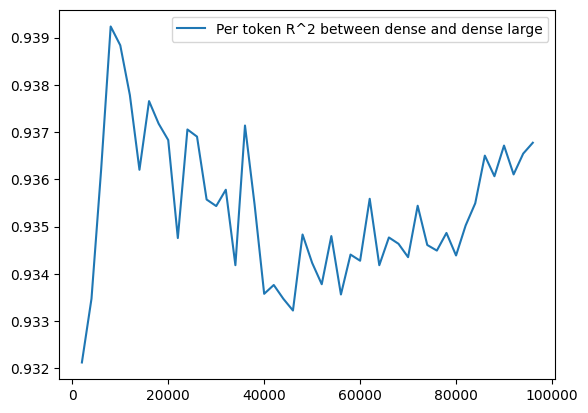

0.9300638884648864


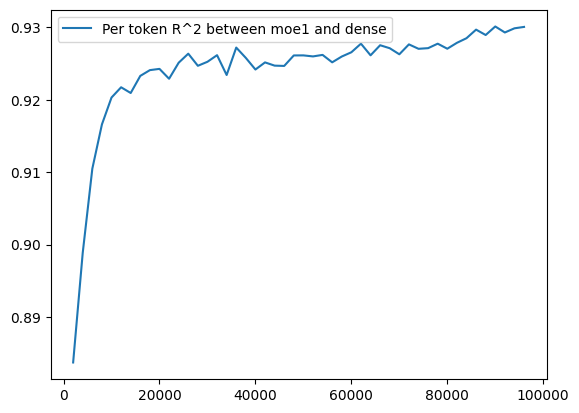

0.9306637192325676


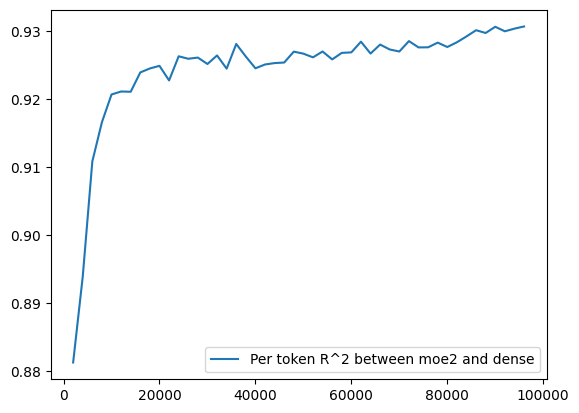

0.9277774653647777


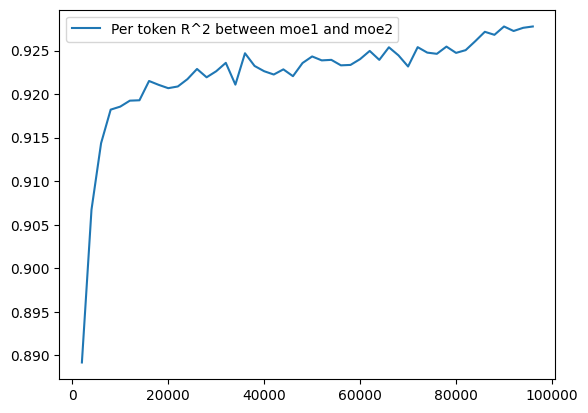

0.9289707455314103


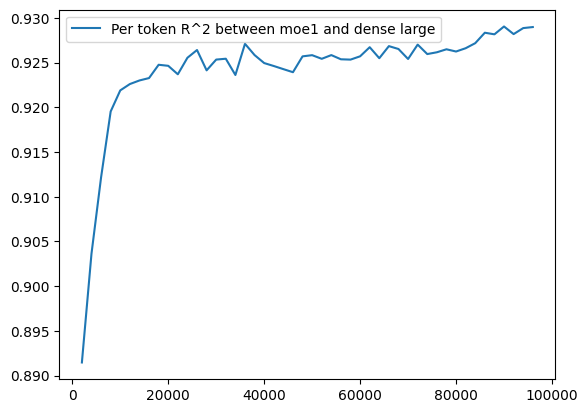

In [34]:
show_line(dense_and_dense["r2"], "Per token R^2 between dense and dense large")
show_line(moe1_and_dense["r2"], "Per token R^2 between moe1 and dense")
show_line(moe2_and_dense["r2"], "Per token R^2 between moe2 and dense")
show_line(moe1_and_moe2["r2"], "Per token R^2 between moe1 and moe2")
show_line(moe1_and_dense_large["r2"], "Per token R^2 between moe1 and dense large")

In [ ]:
import matplotlib.pyplot as plt

def show_line(ln, label):
    leng = len(ln)
    x = [(x + 1) * 2000 for x in range(leng)]

    #print(mean1)
    plt.plot(x, ln, label=label)
    plt.legend()
    plt.show()